# EEG Feature Visualization

This notebook provides interactive visualizations of extracted EEG features and their relationships with remission outcomes.

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from src.utils.config import load_config

Matplotlib is building the font cache; this may take a moment.


## 1. Load Feature Data

In [9]:
# Load configuration
config = load_config('../../configs/processing_config.yaml')

# Get the features path
features_path = config['paths']['features']['window']
# Adjust path to account for notebook location (two directories deep)
adjusted_path = Path('../../../' + features_path)
features_dir = adjusted_path.parent

# Create directory if it doesn't exist
features_dir.mkdir(parents=True, exist_ok=True)

# Check if file exists and provide informative message
if not adjusted_path.exists():
    print(f"Feature file not found at: {adjusted_path}")
    print("You may need to run the feature extraction pipeline first.")
    print("Try running: python -m eeg_analysis.run_pipeline extract-features")
else:
    # Load feature data
    features_df = pd.read_parquet(adjusted_path)
    print(f"Loaded {len(features_df)} samples with {len(features_df.columns)} features")
    
    # Group features by type
    feature_groups = {
        'Spectral': ['bp_', 'rbp_', 'spectral_entropy'],
        'Temporal': ['mean', 'std', 'skew', 'hjorth'],
        'Complexity': ['sample_entropy', 'correlation_dim', 'hurst'],
        'Connectivity': ['xcorr_']
    }
    
    def get_feature_type(feature_name):
        for group, patterns in feature_groups.items():
            if any(pattern in feature_name for pattern in patterns):
                return group
        return 'Other'
    
    # Categorize features
    feature_types = {col: get_feature_type(col) 
                    for col in features_df.columns 
                    if col not in ['Participant', 'Remission']}

{"timestamp": "2025-03-10T03:46:14.545158", "level": "INFO", "name": "src.utils.config", "module": "config", "funcName": "log_config", "message": "Loaded configuration", "taskName": "Task-4", "config": "{\"paths\": {\"raw_data\": \"eeg_analysis/data/raw/MDD_21_subjects_EC_EEG_data_remission_and_non_remission_seperated.mat\", \"interim\": {\"upsampled\": \"data/processed/interim/upsampled\", \"filtered\": \"data/processed/interim/filtered\", \"downsampled\": \"data/processed/interim/downsampled\", \"windowed\": \"data/processed/interim/windowed\"}, \"features\": {\"window\": \"data/processed/features/window_features.parquet\", \"patient\": \"data/processed/features/patient_features.parquet\"}}, \"data_loader\": {\"channels\": [\"af7\", \"af8\", \"tp9\", \"tp10\"], \"validate_data\": true, \"save_interim\": true, \"data_keys\": {\"non_remission\": \"EEG_windows_Non_remission\", \"remission\": \"EEG_windows_Remission\"}}, \"upsampler\": {\"factor\": 2, \"method\": \"linear\", \"save_inter

## 2. Feature Distribution Analysis

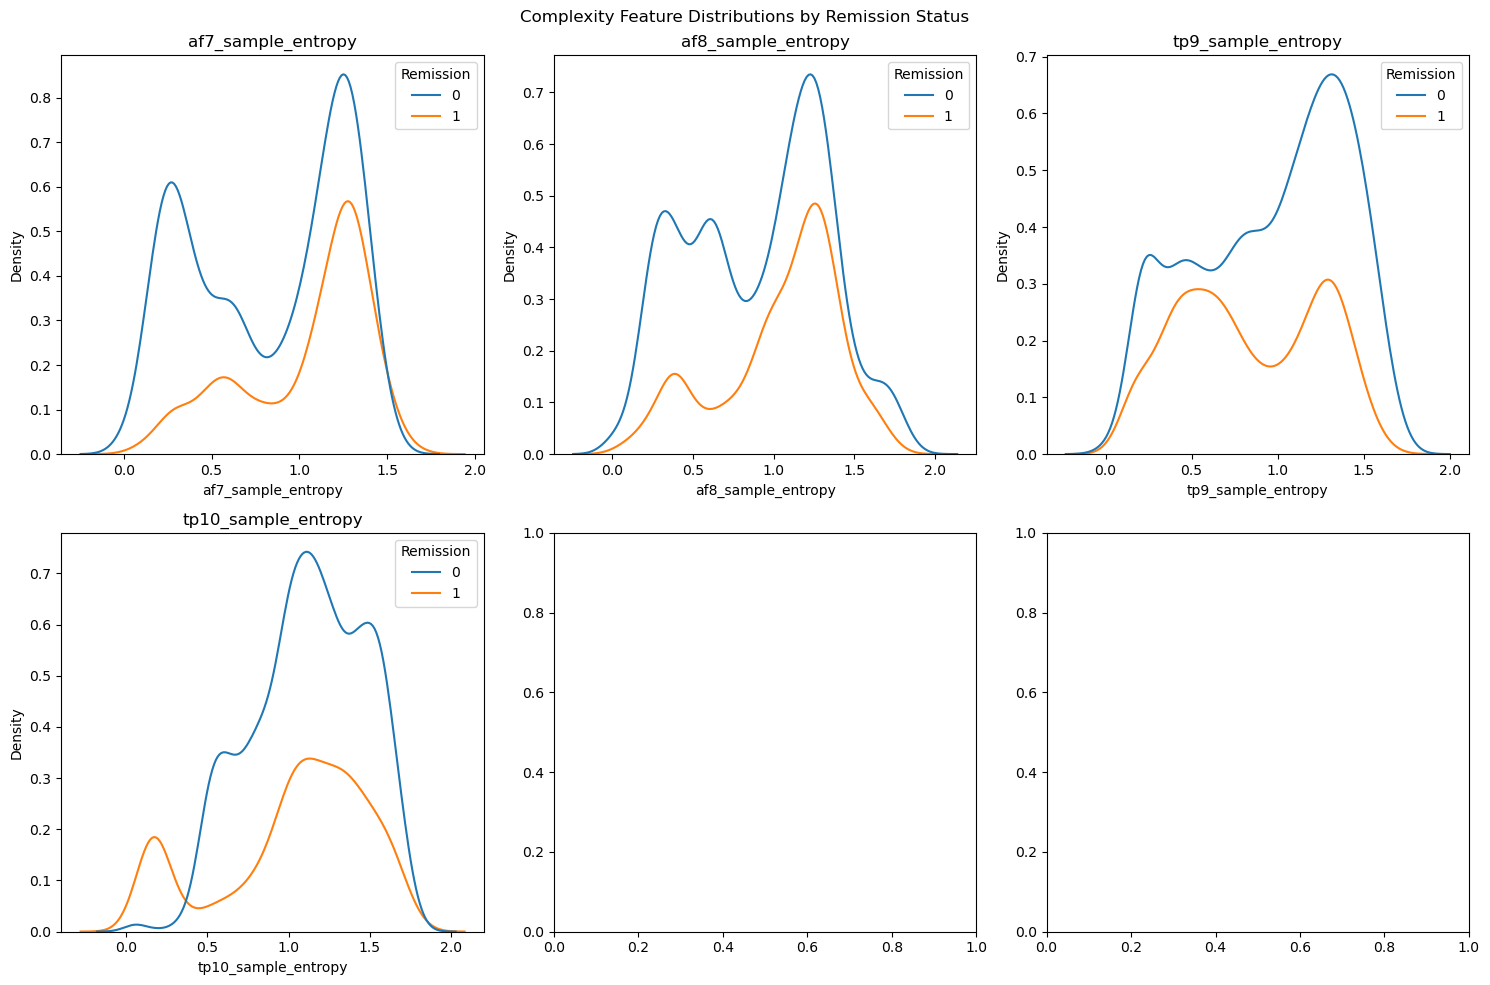

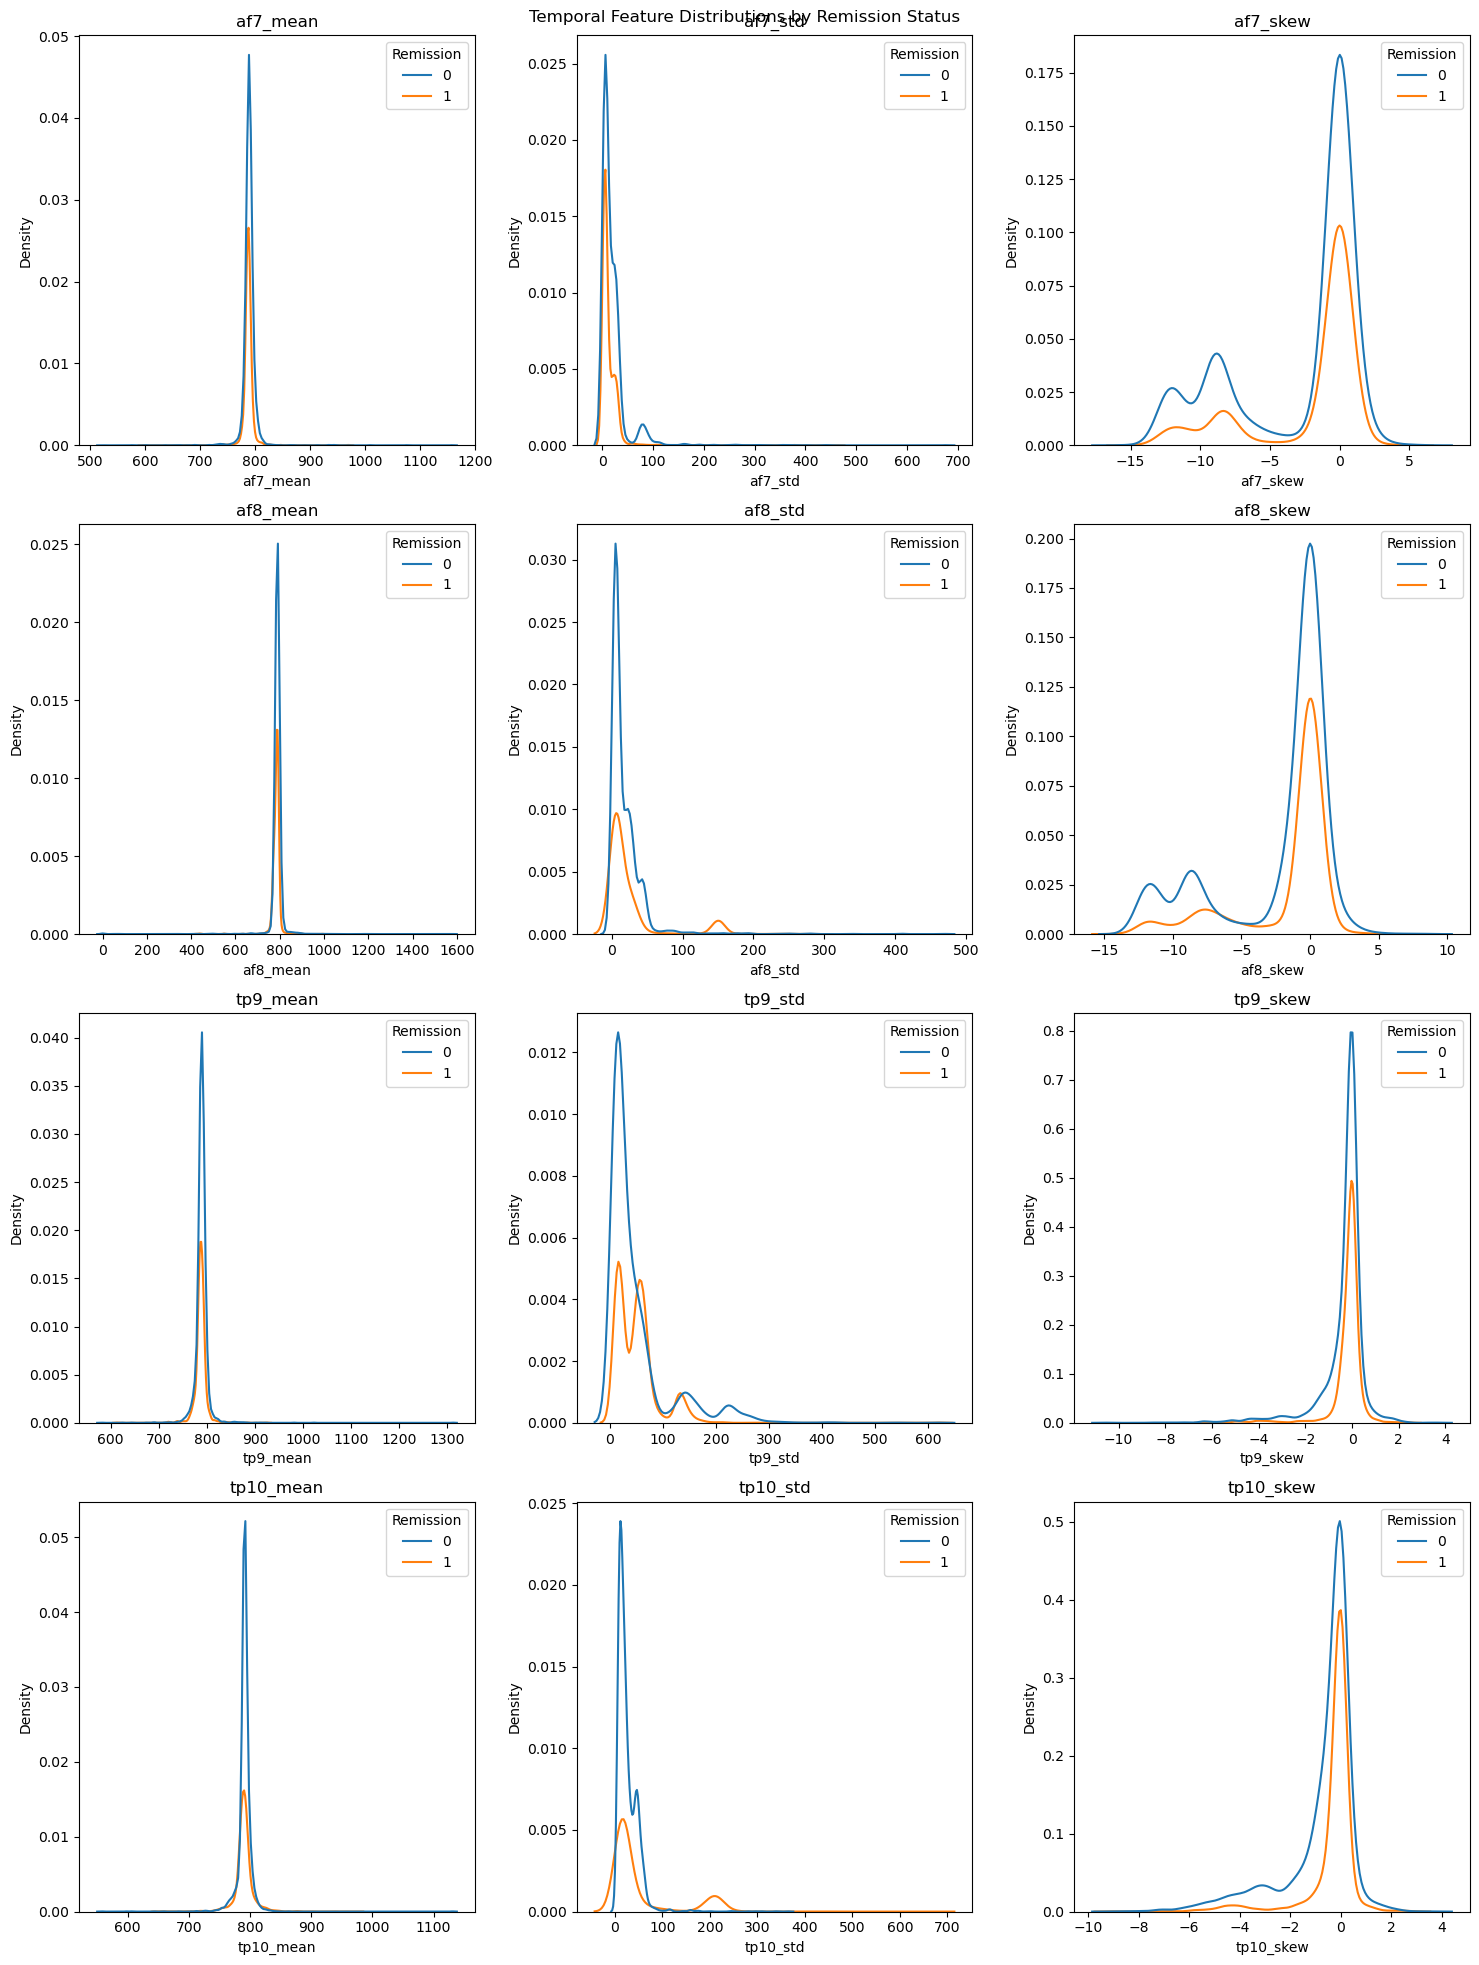

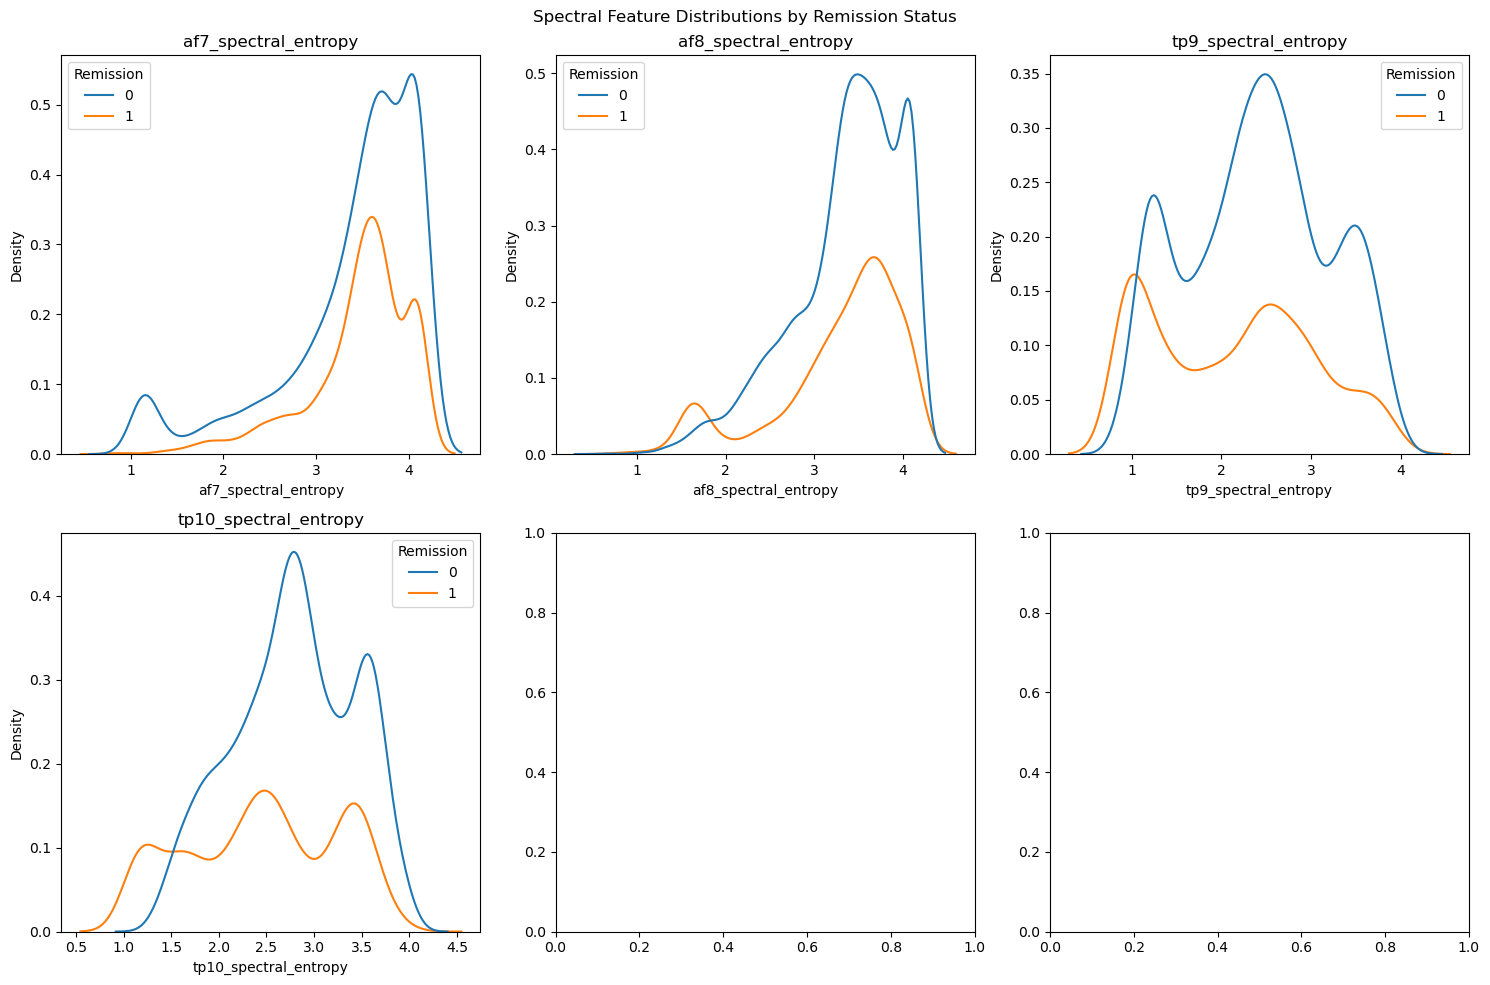

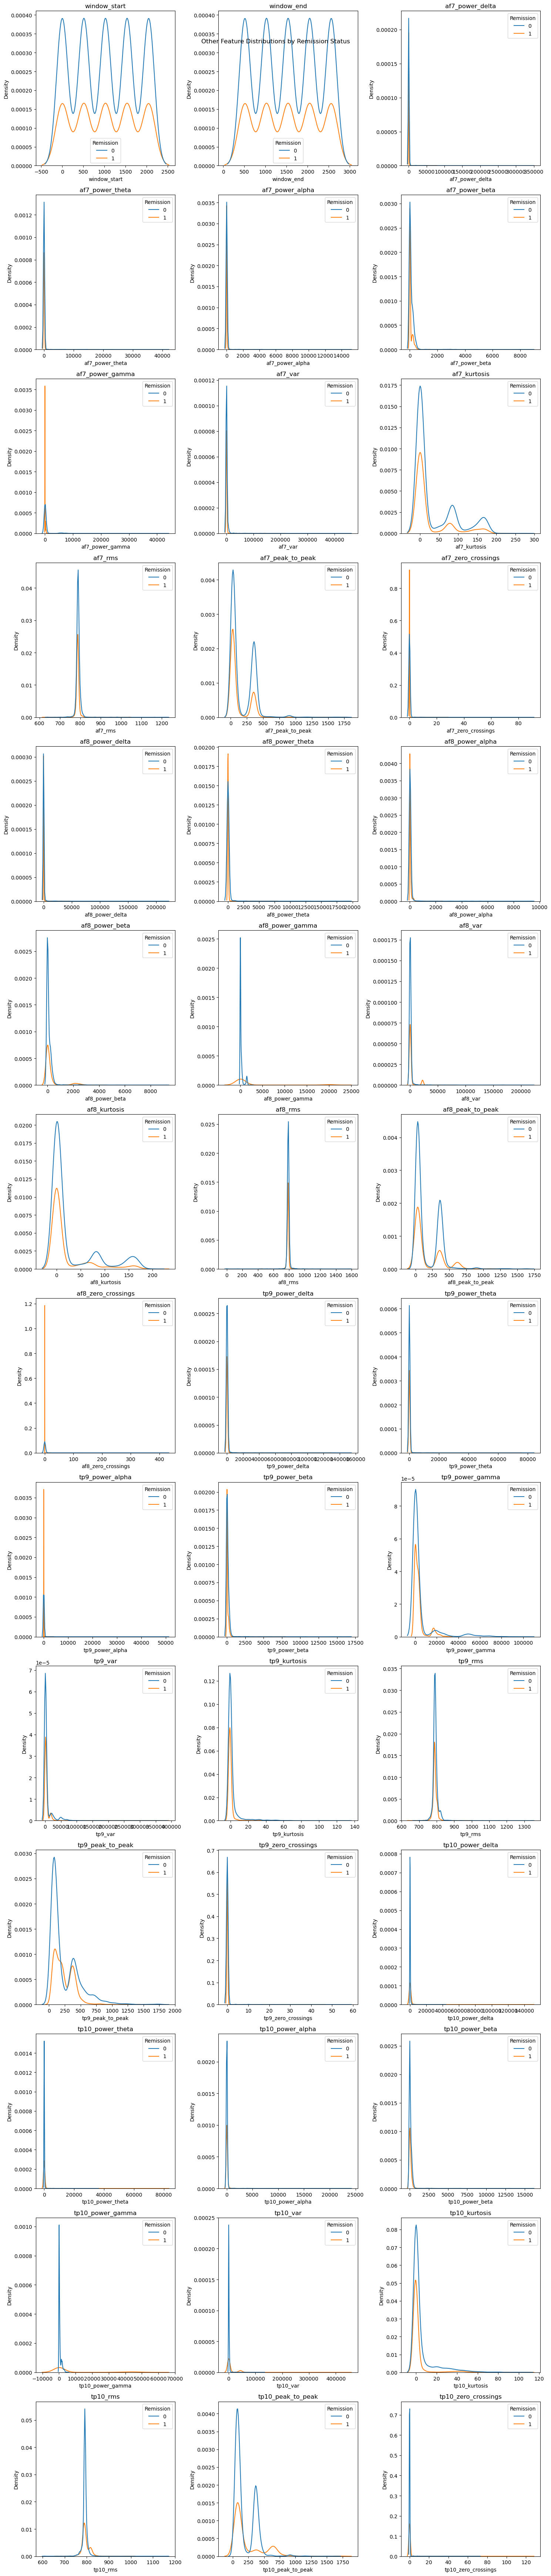

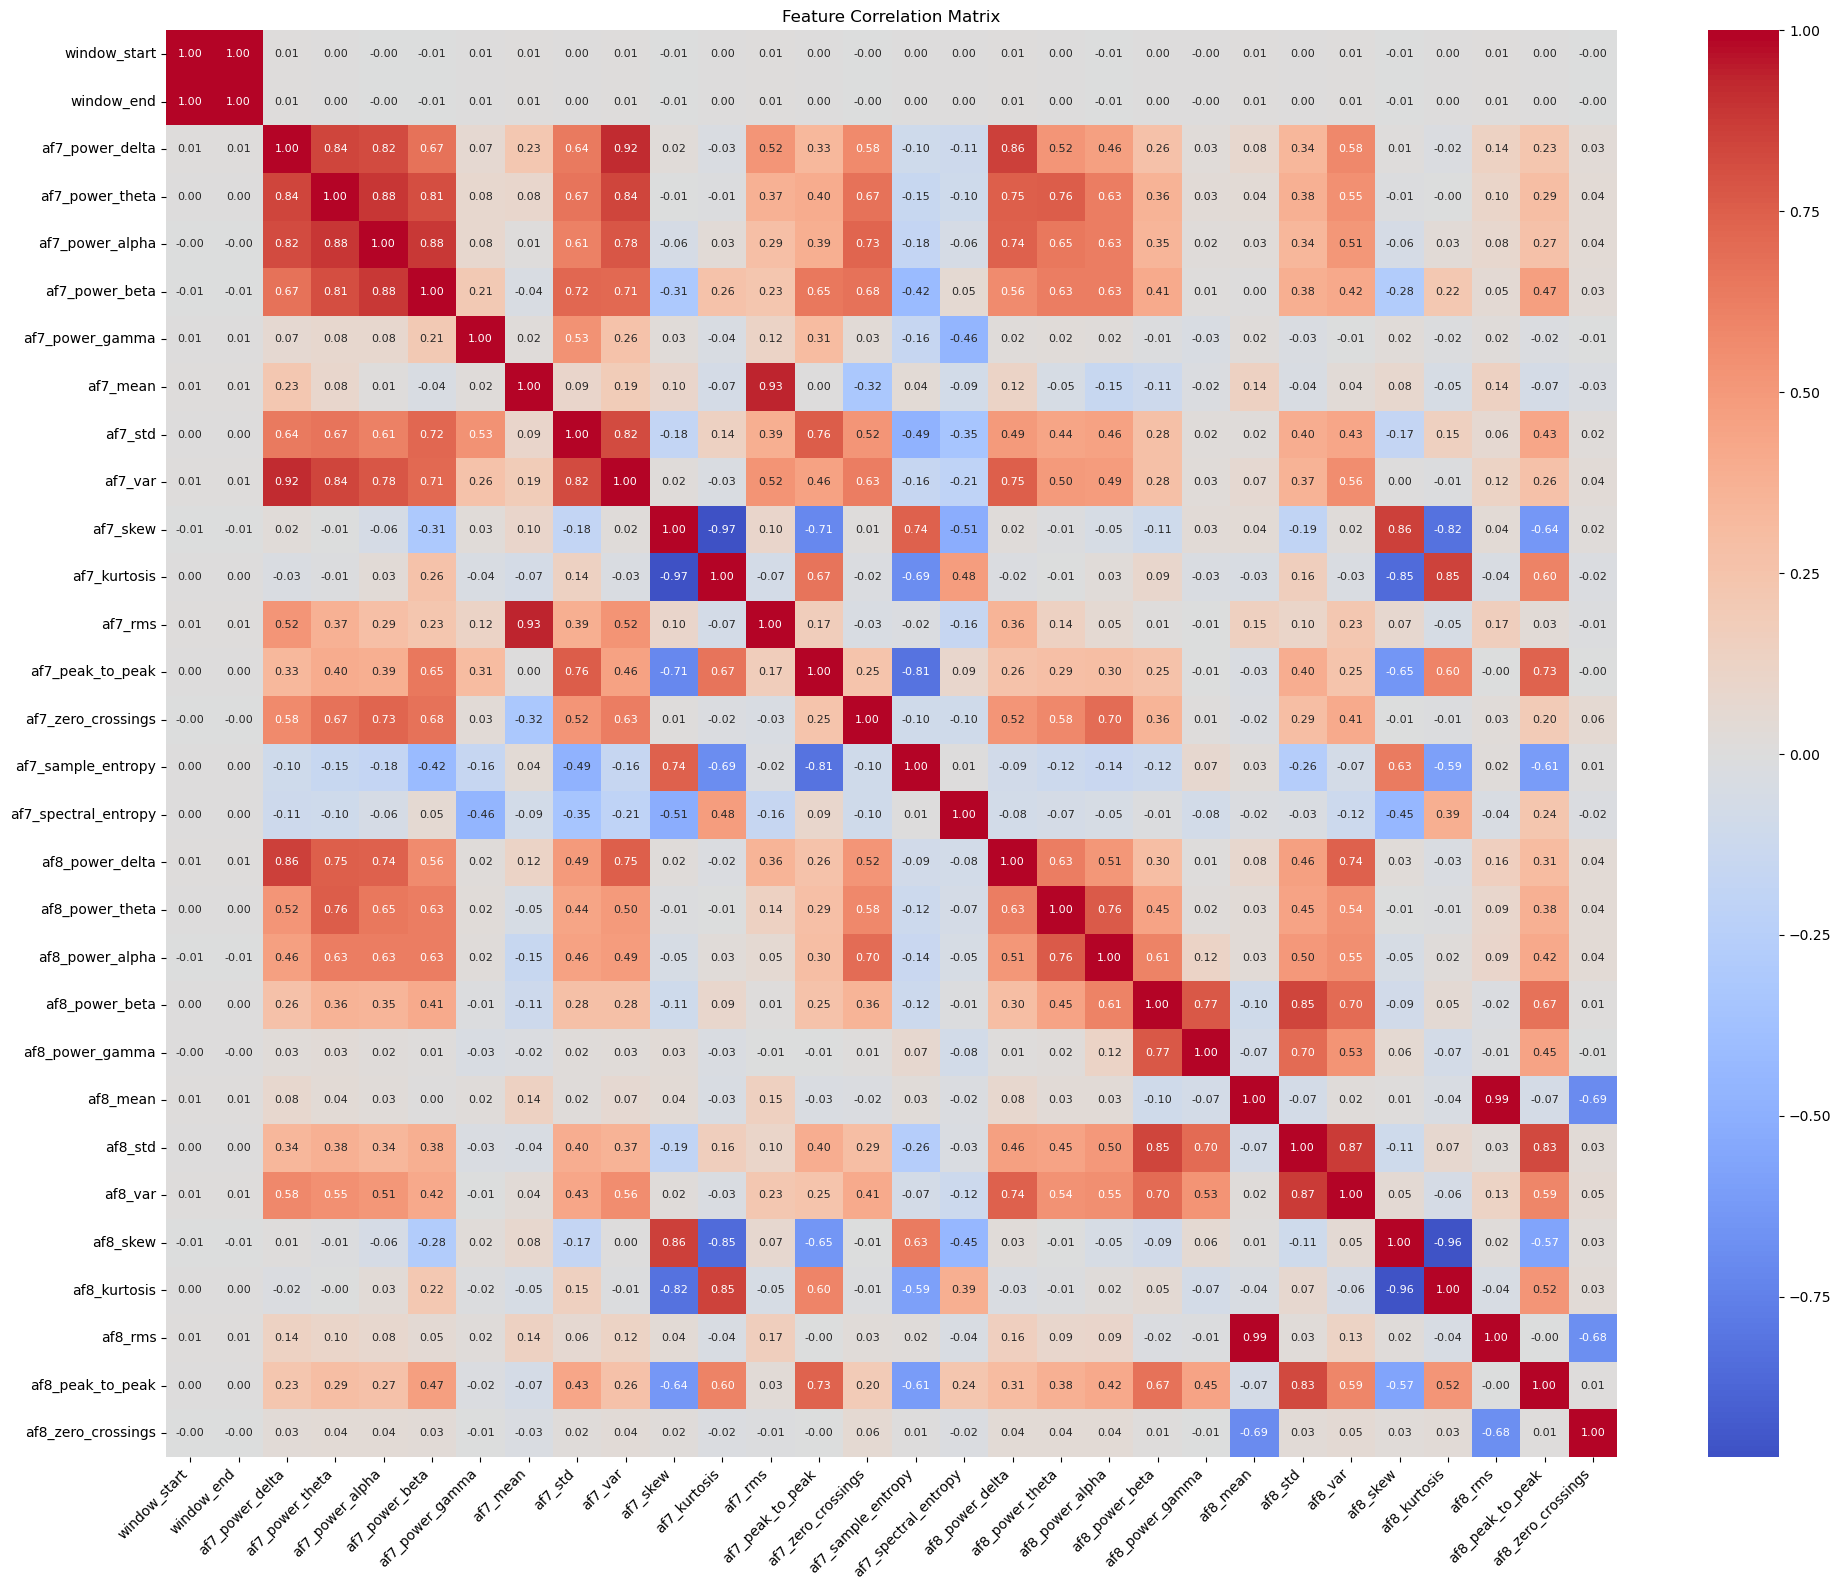

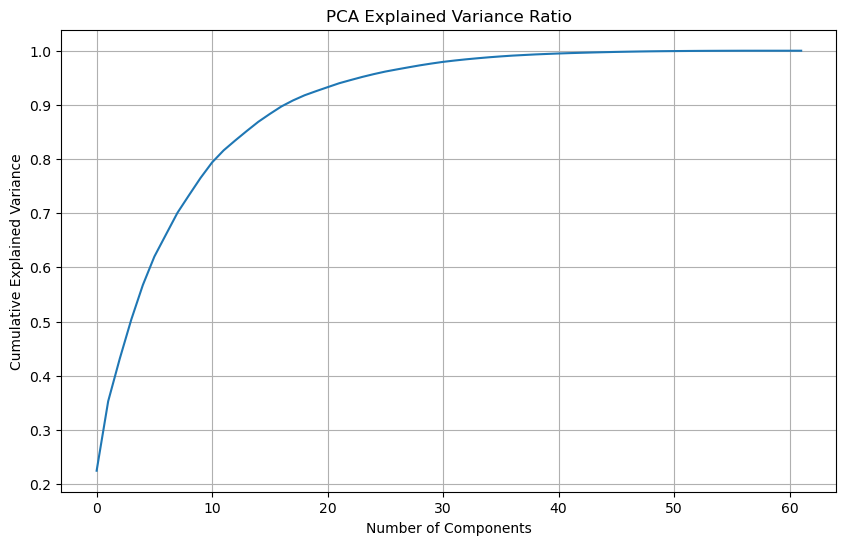

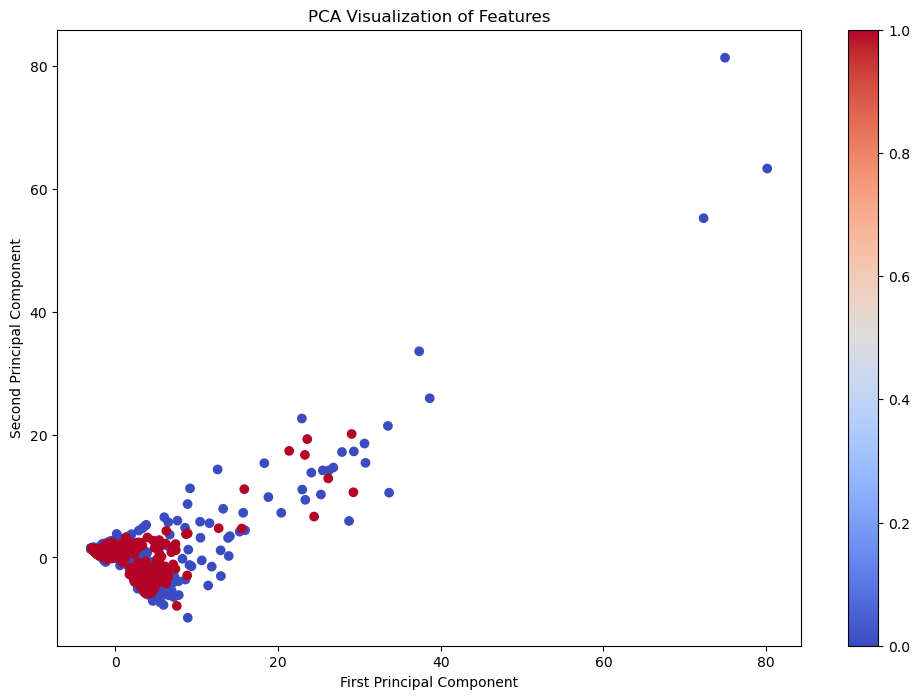

In [11]:
def plot_feature_distributions(df, feature_type):
    """Plot distributions for features of a specific type."""
    features = [f for f, t in feature_types.items() if t == feature_type]
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle(f'{feature_type} Feature Distributions by Remission Status')
    
    for idx, (feature, ax) in enumerate(zip(features, axes.flat)):
        sns.kdeplot(data=df, x=feature, hue='Remission', ax=ax)
        ax.set_title(feature)
        
    plt.tight_layout()
    plt.show()

# Plot distributions for each feature type
for feature_type in set(feature_types.values()):
    plot_feature_distributions(features_df, feature_type)

# Create interactive feature explorer
def create_feature_explorer(df):
    """Create interactive scatter plot of any two features."""
    feature_cols = [col for col in df.columns 
                    if col not in ['Participant', 'Remission']]
    
    # Initialize with the first two features
    if len(feature_cols) >= 2:
        x_col = feature_cols[0]
        y_col = feature_cols[1]
    else:
        print("Not enough feature columns for scatter plot")
        return None
    
    # Create a copy with only necessary columns to avoid type issues
    plot_df = df[['Participant', 'Remission', x_col, y_col]].copy()
    
    fig = px.scatter(plot_df, 
                    x=x_col,
                    y=y_col,
                    template='plotly_white',
                    color='Remission')
    
    fig.update_layout(
        title='Feature Explorer',
        width=900,
        height=600,
        updatemenus=[{
            'buttons': [
                {'args': [{'x': [col]}], 
                 'label': col, 
                 'method': 'update'} for col in feature_cols
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'y': 1.1,
            'name': 'X Feature'
        },
        {
            'buttons': [
                {'args': [{'y': [col]}], 
                 'label': col, 
                 'method': 'update'} for col in feature_cols
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.4,
            'y': 1.1,
            'name': 'Y Feature'
        }]
    )
    
    return fig

create_feature_explorer(features_df)

# Feature correlation analysis
plt.figure(figsize=(20, 16))
selected_features = [f for f in features_df.columns 
                    if f not in ['Participant', 'Remission']][:30]
correlation_matrix = features_df[selected_features].corr()

sns.heatmap(correlation_matrix, 
            xticklabels=True, 
            yticklabels=True,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Dimensionality reduction visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA
X = features_df.drop(['Participant', 'Remission'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot first two components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=features_df['Remission'],
                      cmap='coolwarm')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of Features')
plt.show()
